# Implementation of Variational Bayes Phylogenetic Inference in Julia
Derek Hansen

December 5th, 2020

Stats 701

# Introduction

In this report, I showcase an implementation of the Variational Bayes Phylogenetic Inference (VBPI) method of Zhang and Matsen (2018a) in the Julia language. 

There are two primary parts of this implementation. First, I implement a Subsplit Bayesian Network (SBN) tree structure and write functions which create a one-to-one correspondence with Phylogenetic trees. 
Building on this, I then develop the machinery to perform variational inference via sampling from SBNs. As done in Zhang and Matsen (2018a), this is done by parameterizing the probability of every possible clade-subsplit pair. These probabilities are then learned via maximizing the Evidence Lower Bound (ELBO) as standard in Variational Inference (Blei et al, 2018b). 

I showcase the feasibility of this approach on the same synthetic example as performed in Zhang and Matsen (2018a). In this case, the true posterior distribution to be learned is enumerated over all possible trees. For simplicity, we don't consider the distribution of branch lengths. I show that the variational distribution, despite having many fewer parameters than the full support of trees, is able to identify the trees which are most likely. However, the learned distribution does not seem to perform as well as Zhang and Matsen (2018a).

Crucially, the data structures and functions are written to take advantage of the automatic differentiation provided by the Zygote Julia package (as part of the Flux machine learning package). In other words, there is no hand-differentiation at all in this work. 

# Summary of existing work

### Inference on Phylogenetic Trees
A phyologenetic tree has tree topology $\tau$ and associated branch lengths $q$. We observe the traits of $M$ individuals/specices at $N$ difference sites. This is expressed as the data matrix $Y \in \Omega^{N \times M}$, where $\Omega$ is the
    state-space of different possible traits. The $i$th column of $Y$, $Y_i$, are the observed traits in each individual at site $i$.
    
    
Given a tree $(\tau, q)$, we want to calculate the likelihood $\mathcal P(Y | \tau, q)$.
     We usually assume that the traits are conditionally independent given the tree, i.e.
     $$
       \mathcal P(Y | \tau, q) = \prod_{i=1}^M \mathcal P(Y_i | \tau, q)
     $$

Calculating the likelihood $\mathcal P(Y_i | \tau, q)$  efficiently is a well-studied problem. Hence, we take for granted in this report that once we have the tree, the likelihood can be calculated with reasonable efficiency. 

Equipping a prior  $\mathcal P (\tau, q)$, the posterior density is proportional to the product of the prior and likelihood:
    $$
      \mathcal P (\tau, q | Y) \propto \prod_{i=1}^M \mathcal P(Y_i | \tau, q) \mathcal P(\tau, q)
    $$
    
We cannot directly evaluate nor sample from the posterior distribution of trees. Hence, methods such as Markov Chain Monte Carlo (MCMC) and Variational Inference (VI) are used to recover interesting features of the posterior (such as the mean and credible sets). 

### Subsplit Bayesian Networks


A significant challenge to inference over phylogenetic trees is that the topology of the tree is a random variable. Zhang and Matsen (2018b) developed an equivalent representation of phylogenetic
    trees called "Subsplit Bayesian Networks" (SBNs). An SBN has a fixed topology; specificially, it's a binary tree of depth N-1. Unlike a Phylogenetic tree, each node of an SBN is not an individual, but a representation of a split in the population. 
    
In the next section, we will show how SBNs are defined mathematically, accompanied with Julia code I've written to implement these structures


# Subsplit Bayesian Networks in Julia


## Libraries used

In [1]:
using Revise
using PhyloTrees # I forked this to add labelled leaf nodes: https://github.com/dereklhansen/PhyloTrees.jl
using Plots
using StatsBase
using Flux
using Distributions

In [2]:
include("Sbn.jl") # My code for implementing the SBN data structure (Sbn module)

Main.Sbn

## An example Phylogenetic Tree

In [3]:
import .Sbn.plot_and_annotate

example_tree = Tree();
addnode!(example_tree);

branch!(example_tree, 1, 1.0);
branch!(example_tree, 2, 1.0);
branch!(example_tree, 3, 1.0);
branch!(example_tree, 3, 1.0);
branch!(example_tree, 2, 1.0);
branch!(example_tree, 1, 1.0);
# branch!(example_tree, 1, rand())
example_tree.node_to_label[7] = :D;
example_tree.node_to_label[6] = :C;
example_tree.node_to_label[5] = :B;
example_tree.node_to_label[4] = :A;

example_tree.label_to_node[:D] = 7;
example_tree.label_to_node[:C] = 6;
example_tree.label_to_node[:B] = 5;
example_tree.label_to_node[:A] = 4;

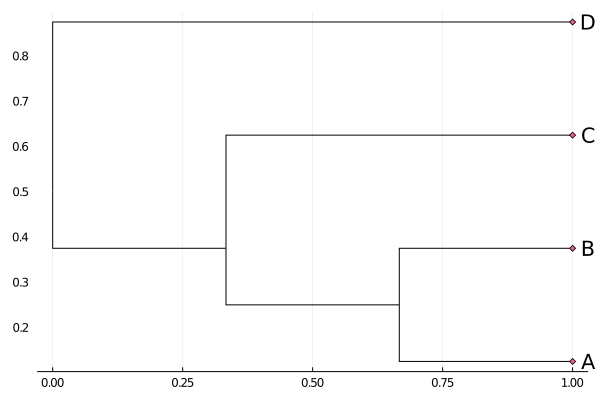

In [4]:
plot_and_annotate(example_tree, true)

 ## Clades and subplits
 
 Before formally describing what SBNs are, we'll need some definitions. 
 
 -  Let $\mathcal X$ be the set of $N$ individuals. For example $\mathcal X = \{A, B, C, D\}$. A **clade** is a non-empty subset of $\mathcal X$ (i.e. $X \in 2^{\mathcal X} \setminus \varnothing$). 


 -  For uniqueness of representation, $\mathcal X$ is equipped with an ordering of individuals. This ordering extends to each clade. Clade $U$ is "less than" a clade $W$, written $U \prec W$, if the lexigraphical ordering of the members of $U$ is less than that of $W$. For example, $\{A, C\} \prec \{B, D\}$.

-  A **subsplit** of clade $C$ is a pair of disjoint clades $S = (W, Z)$ such that:

    1.  $W \cup Z = C$
    2.  $W \prec Z$

For example,  $\{A, C, D\}, \{B\}$ is a subsplit of $\{A, B, C, D\}$.

We represent a clade-subplit in Julia by creating a new type:

In [5]:
clade1 = [:A, :C, :D];
clade2 = [:B];
my_subsplit = Sbn.SubsplitClade(clade1, clade2);

In [6]:
my_subsplit

Main.Sbn.SubsplitClade([:A, :C, :D], [:B])

### The Simplest Subsplit Network

Now, we can define a subsplit network. Suppose we have a population of individuals, $\mathcal X$, of size $N$. Now, let $\mathcal B^*_{\mathcal X}$ be a complete binary tree of depth $N-1$. 
Every node in $\mathcal B^*_{\mathcal X}$ is one of two things:

-  A clade subsplit $(X, Y)$
-  A singleton clade $\{A\}$

The root node of $\mathcal B^*_{\mathcal X}$, $S_0$,  is a subsplit of $\mathcal X$. All child nodes $S_i$, $i \ge 1$, inherit a clade from their parent. If the parent is a subsplit $(X, Y)$, then the child inherits $X$ if it is the first child and $Y$ if it is second. However, if the parent is a singleton clade $\{A\}$, the child inherits $\{A\}$.

Finally, the value of node $S_i$ depends on the clade $C_i$ it inherits. If $C_i$ contains more than one individual, $S_i$ will be a subsplit of $C_i$. Otherwise, if $|C_i| = 1$, then $S_i = C_i$.

Below is an example of one particular choice of $S_1, S_2, \dots, S_7$ on the tree $\mathcal B_\mathcal X^*$


  ![](./fig/fig4.png)

## Equivalence of SBNs and Phylogenetic Trees
Any phylogenetic tree of the individuals in $\mathcal X$ can be written as a particular choice of node values on $\mathcal B_{\mathcal X}^*$. The original phylogenetic tree can be recovered by picking one terminal edge per individual in the expanded tree.

  ![](./fig/fig2.png)

### Getting the equivalent SBN of a Phylogenetic Tree

In [7]:
example_sbn = Sbn.make_sbn(example_tree, 1, missing, 1, missing);
Sbn.print_tree(example_sbn)

Main.Sbn.SubsplitClade([:A, :B, :C], [:D])
├─ Main.Sbn.SubsplitClade([:A, :B], [:C])
│  ├─ Main.Sbn.SubsplitClade([:A], [:B])
│  └─ Main.Sbn.SubsplitClade([:C], missing)
└─ Main.Sbn.SubsplitClade([:D], missing)
   ├─ Main.Sbn.SubsplitClade([:D], missing)
   └─ Main.Sbn.SubsplitClade([:D], missing)


In [8]:
typeof(example_sbn)

Main.Sbn.BinaryNode{Main.Sbn.SubsplitClade}

In [9]:
fieldnames(typeof(example_sbn))

(:data, :parent, :left, :right)

The example_sbn object is a "BinaryNode", which is a parametric data structure from AbstractTrees.jl. In this case, our node has a"SubsplitClade" as its data, and pointers to its "left" and "right" children (which are nodes of the same type).

In [10]:
example_sbn.data

Main.Sbn.SubsplitClade([:A, :B, :C], [:D])

In [11]:
example_sbn.left.data

Main.Sbn.SubsplitClade([:A, :B], [:C])

In [12]:
example_sbn.right.data

Main.Sbn.SubsplitClade([:D], missing)

In [13]:
example_sbn.right.right.data

Main.Sbn.SubsplitClade([:D], missing)

### Getting the equivalent Phylogenetic Tree from a SBN

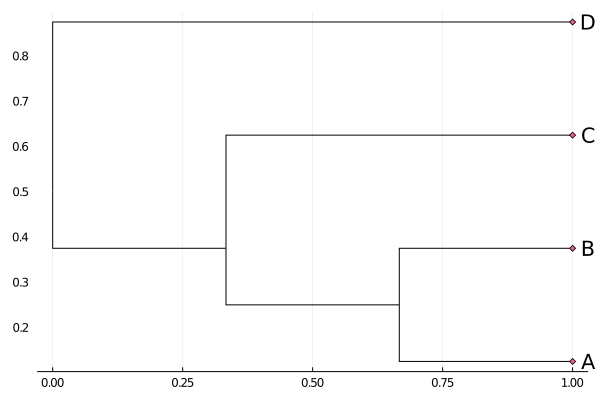

In [14]:
tree_from_sbn = Sbn.make_tree_from_sbn(example_sbn)
plot_and_annotate(tree_from_sbn, true)

## Parameterizing a distribution of SBNs

In [43]:
include("VBPI.jl") # My code for implementing VBPI (VBPILookup module)

Main.VBPILookup

If $T$ is the random topology of the phylogenetic tree and $\tau$ a particular realization, we write the probability in terms of $S_1, \dots, S_{2^{N -1} - 1}$, where $\pi(i)$ are the dependencies of $S_i$ given by the edges of $\mathcal B_{\mathcal X}$.
    $$
      \small
      P(T = \tau) = \mathcal P(S_1 = s_1) \prod_{i > 1} \mathcal P(S_i = s_i | S_{j \in \pi (i)})
    $$ 

To implement this parameterization over SBNs, we create a struct that consists of three objects. 

-  The first is a Dictionary which maps a clade and the first subsplit of that clade to an integer index in 
-  The second is a Dictionary which maps a clade to all possible first-subsplits
-  The third is a vector of logit-probabilities

In [16]:
leaves = [:A, :B, :C, :D]
table = VBPILookup.VBPI(leaves)
typeof(table)

Main.VBPILookup.VBPI{Float64}

In [17]:
fieldnames(typeof(table))

(:lookup_table, :split_dict, :probs)

We store the logit-probabilities this way to be amenable to autodifferentiation. Although the probabities are stored in a vector, we never have to access them directly this way since we can overload the indexing function.

In [18]:
table[[:A, :B, :C, :D], [:A]]

0.0

By default, we initialize the lookup table so for a given clade each subsplit is equally likely. We then can use this table to generate random trees.

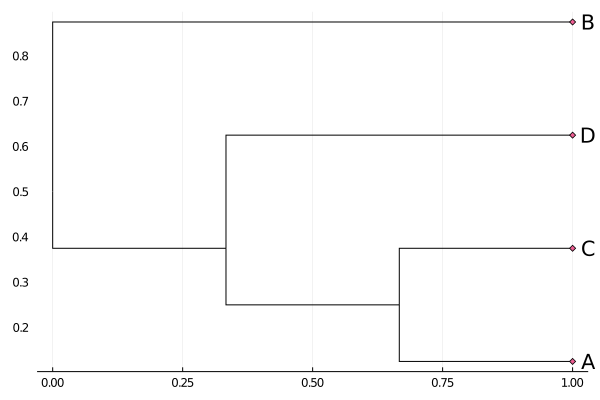

In [19]:
rand_tree, lprob = VBPILookup.rsbn(leaves, table, 1, length(leaves)-1)
VBPILookup.Sbn.plot_and_annotate(rand_tree)

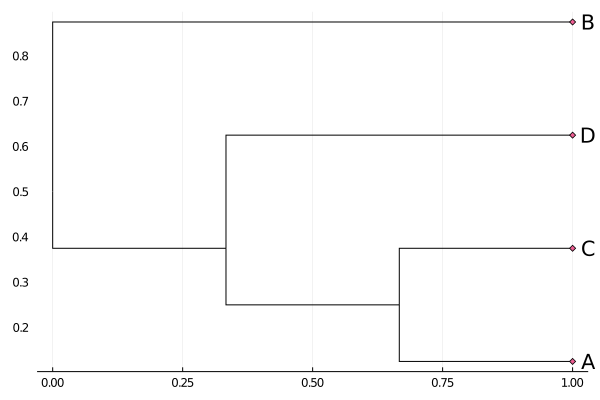

In [20]:
rand_tree, lprob = VBPILookup.rsbn(leaves, table, 1, length(leaves)-1)
VBPILookup.Sbn.plot_and_annotate(rand_tree)

Parameterizing by clade-subsplits has a few advantages. It is more flexible than a "clade"-conditional model, unrooted trees can be accounted for by integrating out $S_1$, and the topology of the SBN is fixed.

The branch lengths $q$ are defined conditional on each tree. These are discussed in Matsen and Zhang (2018a), but for brevity we omit discussion of this distribution.

$$
\mathcal P(T = \tau, q) = \mathcal P(T = \tau) \mathcal P(q | T = \tau)
$$

## Variational Phylogenetic Inference via SBNs

### Creating a probability table of all possible trees

In a real-data setting, our posterior distribution across trees would mostly be driven by the likelihood given the traits of each individual. However, for illustrating our method, our posterior distribution over trees simply assigns a probability to each possible tree. This distribution is drawn from a Dirichlet with parameter $\beta \vec 1$.

To implement such a scheme, we need a way to map each SBN to its probability. Thus, we implemented a function that calculates a unique hash for each tree by recursively hashing the nodes.

In [21]:
Sbn.hashtree(example_sbn)

0x71d4a19960c0540f

These hashes are then used to populate a lookup table.

In [22]:
leaves = [:A, :B, :C, :D]

all_sbns=VBPILookup.enumerate_all_sbns(leaves, 1, length(leaves)-1);

all_sbn_probs = rand(Dirichlet(0.01*fill(1.0, length(all_sbns))))

all_sbn_hash = Sbn.hashtree.(all_sbns)
all_sbn_dict = Dict(zip(all_sbn_hash, all_sbn_probs))

Dict{UInt64,Float64} with 15 entries:
  0xa20ef64cc98565a2 => 0.0191427
  0x71d4a19960c0540f => 4.14381e-12
  0x02aaf70a27f7abb8 => 2.75518e-139
  0x07888e3712341879 => 1.26392e-51
  0x391f9e501ca5c23b => 6.60767e-97
  0xf46b59cbd3f2d10a => 5.45447e-9
  0xe5cd567f874eb13d => 1.98427e-158
  0xa870673ad771a28f => 3.17728e-14
  0x78968d881d9566f9 => 3.75027e-17
  0x958dabca02951ac8 => 0.980857
  0xe5210469fce9ff99 => 2.23258e-15
  0x1090e821a39084a6 => 3.34554e-34
  0xca4cf0e9c15b5973 => 3.3723e-80
  0x9ab1b84ed40fb2b5 => 2.17516e-88
  0xc1a2cace84f2e3fd => 5.10182e-103

In [23]:
all_sbn_dict[Sbn.hashtree(example_sbn)]

4.143806009629161e-12

### Calculating the Evidence Lower Bound (ELBO)

Recall that our goal is to infer the posterior distribution $\mathcal P(\tau, q | Y)$. Variational Inference approaches this problem by attempting to find a variational distribution $Q_\phi$ from a family $\mathcal Q$ parameterized by $\phi$ which minimizes the KL-divergence between them.
  $$
  \begin{split}
        \hat \phi &= \text{argmin}_{\phi} \text{KL}(Q_\phi(\tau, q) || \mathcal P(\tau, q | Y)) \\
        &= \text{argmin}_{\phi} E_{Q_\phi(t, q)} \left(\log \frac {\mathcal P (\tau, q | Y)} {Q_\phi(t, q)} \right)
  \end{split}
  $$
This formulation is not directly usable, since $\mathcal P(\tau, q | Y)$ is intractable.

We can calculate the evidence lower bound (ELBO) instead; we write this as $L(\phi)$. Maximizing the ELBO with respect to $\phi$ is equivalent to minimizing the KL term above.
    $$
    \begin{split}
        L(\phi) &\triangleq E_{Q_\phi(\tau, q)}(\log \mathcal P(\tau, q, Y) - \log Q_\phi(\tau, q)) \\
        &= E_{Q_\phi(\tau, q)}( \log \mathcal P(Y) + \log \mathcal P(\tau, q| Y) - \log Q_\phi(\tau, q)) \\
        &= \log \mathcal P(Y) + E_{Q_\phi(\tau, q)}(\log \mathcal P(\tau, q| Y) - \log Q_\phi(\tau, q)) \\
        &= \underbrace{\log \mathcal P(Y)}_{\text{Evidence}} + \underbrace{\text{KL}(Q_\phi(\tau, q) || \mathcal P(\tau, q | Y))}_{\text{Non-negative divergence}} 
        % &=\int (\log p(x, z) - \log q_\phi (z | x)) d q_\phi (z | x) \\
        % &=\int \left(\log p(x) + \log p(z|x) - \log q_\phi (z | x) \right) d q_\phi (z | x) \\
        % &= \log p(x) + \int \left (\log \frac{p(z|x)} {q_\phi (z | x)} \right) d q_\phi (z | x) \\
        % &= \log p(x) - \mathrm{KL}(q_\phi(z|x) || p(z, x))
    \end{split}
    $$
The integrand of the ELBO is tractable, although the expectation still is not. Hence we use stochastic optimization.
An unbiased estimate of the ELBO $L(\phi)$ is 
$$
\log \mathcal P(\tau^i, q^i, Y) - \log Q_\phi(\tau^i, q^i)
$$
for $\tau^i, q^i \sim Q_\phi(\cdot, \cdot)$. 

In [24]:
for _ in 1:5
    @show VBPILookup.est_elbo(leaves, table, all_sbn_dict)[1]
end

(VBPILookup.est_elbo(leaves, table, all_sbn_dict))[1] = -219.51661231783348
(VBPILookup.est_elbo(leaves, table, all_sbn_dict))[1] = -15.98230789547329
(VBPILookup.est_elbo(leaves, table, all_sbn_dict))[1] = -317.0999363366595
(VBPILookup.est_elbo(leaves, table, all_sbn_dict))[1] = -30.69109504597666
(VBPILookup.est_elbo(leaves, table, all_sbn_dict))[1] = -23.16488398669185


However, a more accurate lower bound to the evidence can be achieved by using multiple iid samples and weighting by their importance:
    $$
      L^K(\phi)  \triangleq E_{Q_\phi(\tau^i, q^i)}\left(\log \left( \frac{1}{K} \sum_{i=1}^K \frac{\mathcal P(\tau^i, q^i, Y)} {Q_\phi(\tau^i, q^i)}  \right) \right)
    $$
We call this objective the "Importance Weighted ELBO" (IW-ELBO). Sampling from the variational distribution, we obtain an unbiased estimate of $L^K (\phi)$: 
$$
\log \left(  \frac{1}{K} \sum_{i=1}^K \frac{\mathcal P(\tau^i, q^i, Y)} {Q_\phi(\tau^i, q^i)} \right)
$$

In [25]:
for _ in 1:5
    @show VBPILookup.est_iwelbo(leaves, table, all_sbn_dict, 100)
end

VBPILookup.est_iwelbo(leaves, table, all_sbn_dict, 100) = 0.06021029771530095
VBPILookup.est_iwelbo(leaves, table, all_sbn_dict, 100) = -0.45567484126691493
VBPILookup.est_iwelbo(leaves, table, all_sbn_dict, 100) = 0.21503090534089164
VBPILookup.est_iwelbo(leaves, table, all_sbn_dict, 100) = 0.22791617927859242
VBPILookup.est_iwelbo(leaves, table, all_sbn_dict, 100) = 0.04110363908624315


Note that as we increase the number of samples $K$ to calculate the objective, $\log \left(  \frac{1}{K} \sum_{i=1}^K \frac{\mathcal P(\tau^i, q^i, Y)} {Q_\phi(\tau^i, q^i)} \right) \to \mathcal P (Y)$ almost surely.

The variational distribution $Q_\phi (\tau, q)$ is parameterized as $Q_\phi(\tau) Q_\phi(q | \tau)$. Since our experiments below only consider different trees, we omit discussion of the distribution of branch lengths. The variational distribution of $\tau$ is based on the SBN parameterization detailed above.
    $$
      Q_\phi(\tau) = Q_\phi(S_1, \dots) = Q_\phi(S_1 = s_i) \prod_{i > 1} Q_\phi(S_i = s_i | s_{j \in \pi(i)} = s_{j \in \pi(i)})
    $$

For every possible parent-child subsplit pair, there is an associated parameter $\phi_{s|t}$. This problem is made tractable by restricting the support of possible pairs over high-probability areas of the posterior (found via bootstrap) $\mathbb S_1$ and $\mathbb S_i (s_{j \in \pi(i)})$ represent these restricted supports.
    $$
      Q_\phi(S_1 = s_1) = \frac{\exp(\phi_{s_1})}{\sum_{s_1^r \in \mathbb S_1} \exp{(\phi_{s_1^r})}}
    $$

$$
    Q_\phi(S_i = s_i | S_{j \in \pi(i)} = s_{j \in \pi(i)}) = \frac{\exp(\phi(s_i | s_{j \in \pi(i)}))}{\sum_{s_i^r \in \mathbb S_i(s_{j \in \pi(i)})} \exp(\phi(s_i^r |s_{j \in \pi(i)}))}
$$

### Stochastic Optimization of the ELBO

Since the $L^K(\phi)$ is optimized using stochastic gradient descent (SGD). In general, 
$$
\nabla_\phi L^K(\phi) \ne  E_{Q_\phi(\tau^i, q^i)}\left(\nabla_\phi\log \frac{1}{K} \sum_{i=1}^K \frac{\mathcal P(\tau^i, q^i, Y)} {Q_\phi(\tau^i, q^i)} \right)
$$ 

The authors use the VIMCO gradient estimator for parameters associated with $\tau$; this reduces the variance by leveraging the multiple samples in $L^K$.
$$
\nabla_\phi L^K(\phi) = E_{Q_\phi (\tau^{1:K})} \sum_{j=1}^K (W_j - \tilde w^j) \nabla_\phi \log Q_\phi(\tau^j)
$$
where:
- $f_\phi(\tau^i) = \frac{\mathcal P(\tau^i, Y)}{Q_\phi (\tau^i)}$ is the unnormalized importance weight of sample $i$;
-  $\hat f_\phi(\tau^{-j}) = \left( \prod_{i \ne j} f_\phi (\tau^i) \right)^{\frac{1}{K-1}}$ is the geometric mean of the unnormalized weights;
- $\tilde w^j = \frac{f_\phi (\tau^j)}{\sum_{i=1}^K f_\phi (\tau^j)}$;
- and $W_j = \hat L^K (\phi) - \log \frac 1 K \left( \sum_{i \ne j} f_\phi (\tau^i) + {\hat f_\phi(\tau^{-1})} \right)$ is a per-sample local-learning signal

In practice, so we can use auto-differentiation tools, we define a "surrogate objective" whose gradient equals the VIMCO gradient. 
$$
\tilde L^K (\phi) \triangleq \sum_{j=1}^K (W_j - \tilde w^j) |_{\phi=\phi} \log Q_\phi(\tau^j)
$$
where the term in parenthesis preceding $|_{\phi=\phi}$ is evaluated at $\phi$ but treated as a constant with respect to $\phi$ when differentiating.

In [26]:
train_obj()  = -VBPILookup.vimco_objective(leaves, table, all_sbn_dict, 100)
params       = Flux.params(table.probs)
for i in 1:2
    L_tilde, ∇ = VBPILookup.gradient_with_loss(train_obj, params)
    @show i
    @show L_tilde
    @show ∇
    @show ∇[table.probs]
    println("")
end
    

i = 1
L_tilde = 0.43985568005732856
∇ = Grads(...)
∇[table.probs] = [2.1848594829117265e-15, -1.0689905769994154e-15, -1.1158689059123103e-15, -2.7259921840475446e-16, 1.2132400705904373e-15, -9.40640852185682e-16, 0.04814283003032064, -0.09628566006064128, 0.04814283003032064, 1.531727134766042e-5, -3.063454269532084e-5, 1.531727134766042e-5, 0.02063920598642796, 0.02063920598643131, 0.020639205986433797, -0.12378928410453395, 0.02063920598642796, 0.02059325417238498, 0.02063920598642796]

i = 2
L_tilde = 0.2782724595229482
∇ = Grads(...)
∇[table.probs] = [-8.30426163493959e-18, 1.987858918486686e-17, -1.1574327549927265e-17, -2.869351024551526e-16, -3.5854824201088316e-16, 6.45483344466036e-16, 0.030460118894696183, -0.060920237789392366, 0.030460118894696183, 6.888133510904332e-6, -1.3776267021808666e-5, 6.888133510904332e-6, 0.01305728872637386, 0.013057288726373894, 0.013057288726378092, -0.0783230679577147, 0.01305728872637386, 0.013036624325841148, 0.01305728872637386]



  ## Their Synthetic Experiment
Zhang and Matsen (2018a) evaluated their method on a synthetic dataset. They consider the sample space of all unrooted phylogenetic trees with 8 leaves (leaving a sample size of 10395). As hinted to earlier, a posterior $p_0(\tau)$ is generated by drawing from a symmetric Dirichlet distribution with concentration parameter $\beta = 0.008$. Since there is no data, the model log evidence is $\log \mathcal P(Y) = 0$, so the tightness of the variational lower bound is known.
Also, branch lengths are not considered


In their experiment, they tested two different sample sizes in calculating bounds: \(20, 50\). They compare the VIMCO estimator with the reweighted-wake-sleep (RWS) objective, which minimizes the KL in the other direcction.

  ![](./fig/experiments_sim.png)

Focusing on KL, the VIMCO with 50 samples in training objective learns the best variational
    distribution. From the right plot, VIMCO slightly underestimates higher-probability areas and over-estimates lower-probability areas. RWS underestimates lower-probability areas.

## Implementing Synthetic Experiment in Julia

Here we perform a similar experiment to the synthetic experiment in Zhang and Matsen (2018a). The only difference is that we consider all rooted trees of 7 individuals (which has the same sample size).

In [129]:
leaves=[:A, :B, :C, :D, :E, :F, :G]

7-element Array{Symbol,1}:
 :A
 :B
 :C
 :D
 :E
 :F
 :G

In [130]:
all_sbns=VBPILookup.enumerate_all_sbns(leaves, 1, length(leaves)-1);

all_sbn_probs = rand(Dirichlet(0.008*fill(1.0, length(all_sbns))))

all_sbn_hash = Sbn.hashtree.(all_sbns)
all_sbn_dict = Dict(zip(all_sbn_hash, all_sbn_probs))

Dict{UInt64,Float64} with 10395 entries:
  0xe86bb02926f15f5f => 1.31701e-42
  0xacf12cca9d4ed0ab => 6.68894e-30
  0xaf769f7de8e6e7e6 => 5.39837e-106
  0x53e0f3ca6517d2a6 => 1.95738e-92
  0xf1d5e3ff57ce4ef5 => 2.03634e-105
  0x5958a1748a0eba0f => 2.60571e-33
  0x5be3301d4863345e => 1.58984e-7
  0x96c478fb5e9209cf => 2.55027e-51
  0x8ffdbeb31051701d => 1.85762e-5
  0xf05f8b68627381f6 => 5.80306e-106
  0x4e0e001b6e82a5c8 => 1.43567e-8
  0xf630b979a3a0ddb3 => 6.92443e-9
  0x590a10265cc541b6 => 6.42426e-126
  0xb3c22cea9e7f6785 => 8.93264e-86
  0x745fe4356016c723 => 7.68897e-102
  0xc0a68f2ffe6bbdac => 1.06009e-16
  0xdd85e5795169ad39 => 1.89002e-74
  0x74ee3ff43a61a6fa => 2.55743e-28
  0xd33feb1f8ffb17cf => 2.89879e-32
  0xbae82a43b1bdaff4 => 5.17656e-17
  0x1b9d6be63dd003ba => 2.64969e-162
  0x88ad7f55811bc7e5 => 8.96543e-8
  0xd920d1cb8a60ed68 => 3.76158e-29
  0x0622aceedb1832d1 => 7.70699e-92
  0x6d07d7e817c39035 => 5.08317e-11
  ⋮                  => ⋮

Here is what one example tree looks like:

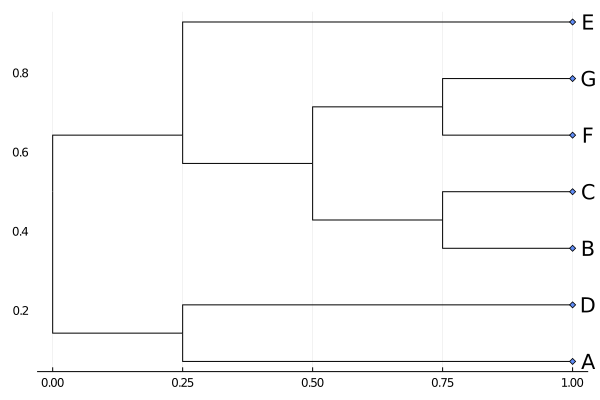

In [131]:
VBPILookup.Sbn.plot_and_annotate_sbn(all_sbns[1234])

In [132]:
leaves = [:A, :B, :C, :D, :E, :F, :G]
table = VBPILookup.VBPI(leaves)
typeof(table)

Main.VBPILookup.VBPI{Float64}

Note that it is not possible for this variational distribution to exactly match any distribution of trees. This is because the number of parameters in the variational distribution is about 9% of the total number of possible trees.

In [133]:
@show length(table.lookup_table); ## Number of variational parameters
@show length(all_sbn_dict); ## Number of trees (# of params in distribution)
@show length(table.lookup_table) / length(all_sbn_dict);

length(table.lookup_table) = 945
length(all_sbn_dict) = 10395
length(table.lookup_table) / length(all_sbn_dict) = 0.09090909090909091


We wrap up all of the stochastic optimization code into the "train_sbn" function. To match Zhang and Matsen, we run this for 200,000 epochs. We use the VIMCO-estimated gradient at each callback step, but we also calculate the real loss every 200 iterations to test convergence.

In [134]:
losses = VBPILookup.train_sbn(leaves, table, all_sbn_dict; epochs=200_000, cb=20_000, calc_loss_every=200, opt=ADAM(1e-3))

020000: loss =  0.680 (Time elapsed = 451.111 sec)
040000: loss = -0.286 (Time elapsed = 960.801 sec)
060000: loss = -0.000 (Time elapsed = 1480.681 sec)
080000: loss =  0.567 (Time elapsed = 2003.639 sec)
100000: loss =  0.537 (Time elapsed = 2520.157 sec)
120000: loss = -0.091 (Time elapsed = 3038.613 sec)
140000: loss =  0.267 (Time elapsed = 3547.916 sec)
160000: loss = -0.220 (Time elapsed = 4072.860 sec)
180000: loss =  0.762 (Time elapsed = 4594.027 sec)
200000: loss = -0.252 (Time elapsed = 5097.778 sec)
Total time taken: 5097.778 sec


1000-element Array{Float64,1}:
 -1.8464473990935812
  3.72696427232931
  1.6209368670061077
  2.351889853476223
  7.905985052299734
  2.916879058390877
 11.465585874945571
  1.6102347184319368
  0.9926070417573833
  0.2456347120333895
 -2.190100476368944
  3.2129668170246024
 -0.039087605954332805
  ⋮
 -0.3641987090489436
  0.89265852493341
 -0.22974073147514806
  0.013124187117961927
 -0.10638268858731914
  0.2830249297347813
  0.40034433982627027
 -0.16148732950724787
  0.11112347489750407
  0.162509444900794
 -0.05920385510291437
 -0.2520448156184263

In [122]:
using BSON: @save, @load
@save "vi_model_7leaves.bson" table

The ELBO converges well within 200,000 epochs. The total run time was 5097 seconds (about 85 minutes), or about 0.02 sec / epoch.

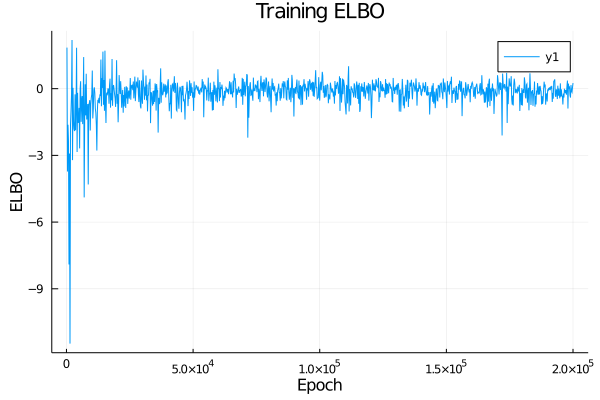

In [136]:
plot(200:200:200_000, -losses, title="Training ELBO", xlabel="Epoch", ylabel="ELBO")

Most of the top ten trees in the sample are highly ranked in the variational distribution as well.

In [137]:
logq=VBPILookup.dsbn.([leaves], all_sbns, [table], [1], [length(leaves)-1])
using DataFrames
res_sorted_by_true = DataFrame((hash = all_sbn_hash, prob_true = all_sbn_probs, prob_q = exp.(logq))) |>
    x -> sort(x, :prob_q, rev=true) |>
    x -> (x.rank_q = 1:size(x, 1); x) |>
    x -> sort(x, :prob_true, rev=true) |>
    x -> first(x, 10) 
    

,hash,prob_true,prob_q,rank_q
,UInt64,Float64,Float64,Int64
1,15042891786743301983,0.0448956,0.0157675,1
2,1511389418650230179,0.027254,0.00872917,2
3,11970839676207041303,0.0272479,0.00684512,3
4,10413187684172510843,0.0246941,0.00653054,4
5,5280375419092571341,0.0246275,0.00591232,5
6,8051974844296862248,0.0194727,0.00346199,14
7,2198118317968373466,0.0170851,0.00285082,28
8,1581504301888698434,0.0170356,0.00312699,23
9,1631796177322814,0.0161698,0.00206472,69


Here, we show the probabilitity of the variational distribution plotted against the true probability (with the ideal line plotted for comparison). When looking at the highest probability trees, the approximation looks pretty good, although many trees were underfit

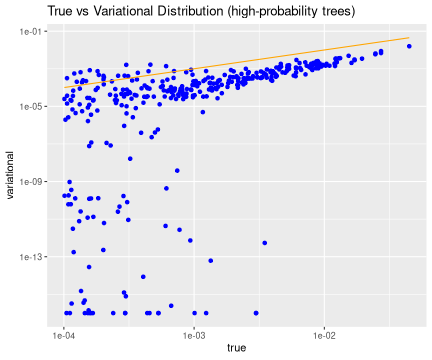

RObject{VecSxp}


In [154]:
using RCall
R"
library(tidyverse)
compare_tbl = tibble(true=$all_sbn_probs, variational=$(exp.(logq))) %>%
    mutate(true = ifelse(true < 1e-16, 1e-16, true), variational = ifelse(variational < 1e-16, 1e-16, variational)) %>%
    filter(true > 1e-4)
ggplot(compare_tbl, aes(x=true)) + 
    geom_point(aes(y=variational), color='blue') +
    geom_line(aes(y=true), color='orange') + 
    scale_y_log10() + 
    scale_x_log10() + 
    ggtitle('True vs Variational Distribution (high-probability trees)')
"

On the other hand, when we look at all trees, the variational distribution does not fit low-probability trees well at all. 

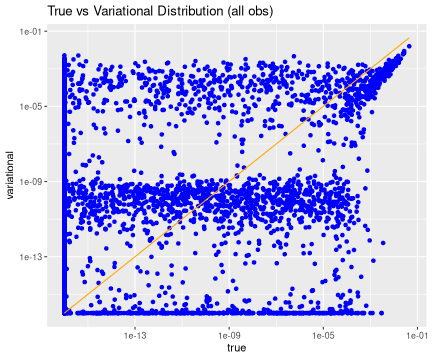

RObject{VecSxp}


In [156]:
using RCall
R"
library(tidyverse)
compare_tbl = tibble(true=$all_sbn_probs, variational=$(exp.(logq))) %>%
    mutate(true = ifelse(true < 1e-16, 1e-16, true), variational = ifelse(variational < 1e-16, 1e-16, variational))
ggplot(compare_tbl, aes(x=true)) + 
    geom_point(aes(y=variational), color='blue') +
    geom_line(aes(y=true), color='orange') + 
    scale_y_log10() + 
    scale_x_log10() + 
    ggtitle('True vs Variational Distribution (all obs)')
"

When comparing how the variational distribution assigns probability compared to the true distribution, we see that the variational distribution seems to correctly rank the probability of trees which are high probability, but consistently underestimates their probability. while overestimating the probability of several unlikely trees. 

This is likely due to the parameterization of the variational distribution. Assigning probability by clade-splits regularizes the distribution to be similar for trees that contain splits in common. However, this regularity does not exist in our synthetic distribution. Because of this, I think this synthetic distribution is actually harder to learn than a real experiment, because there is no geometric structure to the probabilities of trees. In real phylogenetic data, I suspect trees with similar clade-splits will have similar posterior probabilities.

I am also surprised that Zhang and Matsen (2018a) did much better in their synthetic example. It is hard to say exactly what they did differently. For one, I did not do a proper hyperparameter search; perhaps they used a lower learning rate in the stochastic gradient descent. This is supported by the fact that their ELBO converges much more slowly.

# References

Blei, D. M., Kucukelbir, A., & McAuliffe, J. D. (2017). Variational Inference: A Review for Statisticians. Journal of the American Statistical Association, 112(518), 859–877. https://doi.org/10.1080/01621459.2018.1285773

Zhang, C., & Matsen IV, F. A. (2018a, September 27). Variational Bayesian Phylogenetic Inference. International Conference on Learning Representations. https://openreview.net/forum?id=SJVmjjR9FX

Zhang, C., & Matsen IV, F. A. (2018b). Generalizing Tree Probability Estimation via Bayesian Networks. ArXiv:1805.07834 [Stat]. http://arxiv.org/abs/1805.07834